Pylbm for solids.

Pylbm is a python-package for numerical simulations using the Lattice-Boltzmann-Method (LBM). For more general information, refer to the website https://pylbm.readthedocs.io/en/latest/, this documentation will focus on the scope of the project, which is to extend and use pylbm to solve equations of quasi-static linear elasticity in 2D. 

Here we will take a deeper dive into the handling of boundary conditions in pylbm. All relevant source code can be found in `pylbm/boundary.py`. 

### 1. Recap
As we saw in the introductory notebooks, boundary conditions can be applied with the `boundary_conditions` key in the dictionary, e.g. 
```python
'boundary_conditions': {1: {'method': {0: pylbm.bc.LEDirichlet2D}, 'value': bc_1},
                        2: {'method': {0: pylbm.bc.LENeumann2D},   'value': bc_2},
                        },
```
where we specify Dirichlet boundary conditions for the boundary labeled as 1, and Neumann conditions for the one labeled 2. Bounds with a specific label do not necessarily have to be connected, all bounds with label 1 will have Dirichlet boundary conditions, however in that case one should make sure that the expression given for `'value'` is valid for all these bounds. 

pylbm then creates an instance of the class `Boundary`, called `pylbm.Simulation.bc` which only serves to identify and list all boundary methods that will be used and the nodes where they will be applied. The methods themselves are described by their own classes, derived from a base `BoundaryMethod` class. Instances of these method classes are listed in `pylbm.Simulation.bc.methods`. Below we create a simulation and see that we can find the boundary method classes in `sim.bc.methods`.


In [1]:
import sympy as sp
import pylbm
import numpy as np

#geometry
dx = 0.1
dt = 0.1
la = dx/dt
L_box = 1.

#characteristic dimensions
U = 1.
L = dx
T = dt

#geometry in lattice units
dx_nd = dx/L
L_box_nd = L_box/L
la_nd = 1.

#shapes to construct a plate with hole geometry (note that parameters are scaled to lattice units)
shape_1 = pylbm.Parallelogram((0,0), (1/L, 0), (0, 1/L), label=1, isfluid=True)
shape_2 = pylbm.Circle((0.5/L,0.5/L), 0.25/L, label=2, isfluid=False)

#material parameters (actual values and in lattice units)
E = 0.1/0.1731
E_nd = T/(L*L)*E
nu = .7
K = E/(2*(1-nu))
K_nd = K*T/L**2
mu = E/(2*(1+nu))
mu_nd = mu*T/L**2
theta = 1/3

#define symbols
u, v, LA = sp.symbols('u, v, LA')
THETA, MU_ND, K_ND, GAMMA = sp.symbols('THETA, MU_ND, K_ND, GAMMA')

#moment matrix
M = sp.Matrix([[1,0,-1,0,1,-1,-1,1],[0,1,0,-1,1,1,-1,-1],[0,0,0,0,1,-1,1,-1],[1,1,1,1,2,2,2,2],
    [1,-1,1,-1,0,0,0,0],[0,0,0,0,1,-1,-1,1],[0,0,0,0,1,1,-1,-1],[GAMMA,GAMMA,GAMMA,GAMMA,1+2*GAMMA,1+2*GAMMA,1+2*GAMMA,1+2*GAMMA]])

#equilibrium moments in order
Meq = [u,v,0,0,0,THETA*u,THETA*v,0]

#relaxation parameters
w10 = 0.
w01 = 0.
w11 = 1/(MU_ND/THETA+.5)
ws = 1/(2*K_ND/(1+THETA)+.5)
wd = 1/(2*MU_ND/(1-THETA)+.5)
w12 = 1.5
w21 = 1.5
wf = 1.
omega = [w10,w01,w11,ws,wd,w12,w21,wf]
gamma = theta*.5/((1+theta)*((1/ws-.5).evalf(subs={K_ND:K_nd,THETA:theta})-.5))

#boundary conditions
def bc_1(f, m, x, y):
    m[u] = 1e-7*((x*L)**2-(y*L)**2)
    m[v] = 1e-7*np.sin(x*y*L**2)
    
def bc_2(f, m, x, y):
    m[u] = 0.
    m[v] = 0.

#initial condition
def u_init(x,y):
    return 0.

def v_init(x,y):
    return 0.

dico = {
    'box' : {'x': [0,L_box_nd], 'y': [0,L_box_nd], 'label': 1},
    'elements': [shape_1, shape_2],
    'space_step': dx_nd,
    'scheme_velocity': LA,
    'parameters': {LA: la_nd,
            THETA: theta,
            MU_ND: mu_nd,
            K_ND: K_nd,
            GAMMA: gamma,
            },
    'init': {u: u_init, v: v_init},
    'boundary_conditions': {1: {'method': {0: pylbm.bc.LENeumann2D}, 'value': bc_1},
                            2: {'method': {0: pylbm.bc.LEDirichlet2D}, 'value': bc_2},
                            },
    'generator': 'cython',
    'lbm_algorithm': {'name': pylbm.algorithm.BaseAlgorithm},
    'schemes':[
            {
                'velocities': list(range(1,9)),
                'conserved_moments': [u,v],
                'M': M,
                'equilibrium': Meq,
                'relaxation_parameters': omega,
                'source_terms': {u: 0., v: 0.}
                }]
    }

sim = pylbm.Simulation(dico)

In [2]:
#list all boundary methods we use in our simulation
sim.bc.methods

### 2. Overview
Let's see what happens when we create and compute a simulation. As our entry point, we identify the the parts in our main simulation class where methods from the boundary classes are called. In `pylbm/simulation.py` we have (l.153) 
```python
def _initialize(self):
        # Initialize the solution and the rhs of boundary conditions
        self.initialization()
        for method in self.bc.methods:
            method.prepare_rhs(self)
            method.fix_iload()
            method.set_rhs()
            method.move2gpu()
        self._need_init = False

```
which initializes all boundary method classes. We will see later what these methods do, important here is that this function is only called once during the initialization of a simulation. Next, still in `pylbm/simulation.py` (l.365):
```python
def boundary_condition(self, **kwargs):
        """
        perform the boundary conditions

        Notes
        -----

        The array _F is modified in the phantom array (outer points)
        according to the specified boundary conditions.
        """
        f = self.container.F
        f.update()

        for method in self.bc.methods:
            method.update_feq(self)
            method.set_rhs()
            method.update(f, **kwargs)
```
This function will be called in every time step to apply the boundary conditions, as we can see in the main function for computing a time step below (l.384). Like all other steps, the boundary methods generate code, which will be called when simulating through `method.update(f, **kwargs)`. However, the heavy lifting in terms of computation for the boundary methods is actually done in `method.update_feq(self)`and `method.set_rhs()` and results from there are passed on to the generated code which completes a quick loop over all boundary nodes.     
```python
def one_time_step(self, **kwargs):
        """
        compute one time step

        Notes
        -----

        Modify the arrays _F and _m in order to go further of dt.
        This function is equivalent to successively use

        - boundary_condition
        - transport
        - f2m
        - relaxation
        - m2f
        """
        if self._need_init:
            self._initialize()

        self._update_m = True # we recompute f so m will be not correct

        self.boundary_condition(**kwargs)

        self.algo.call_function('one_time_step', self, **kwargs)
        self.container.F, self.container.Fnew = self.container.Fnew, self.container.F

        self.t += self.dt
        self.nt += 1

```
### 3. iload, istore
Before we investigate individual methods, let's clear up some of the important and reoccurring attributes. The basic problem with boundaries in lbm is of course that some populations are missing at boundary nodes, specifically those which would come in from a direction that points from the outside to the inside of the domain. The way that pylbm tackles this problem is by reconstructing these missing populations and __storing them at ghost nodes outside the domain, in the travel direction of the corresponding population__ such that these reconstructed populations get transported from the outside to the inside of the domain in the transport step. This way, for every node inside the domain, it looks as though no population is missing. The boundary classes conveniantly have two attributes that list all nodes at which this is happening. 
`method.iload` stores the index of all nodes __inside__ the domain, which have travel directions that leave the domain. 

                [ iv ix iy ]
                [ iv ix iy ]
                  .  .  .
     iload =      .  .  .
                  .  .  .
                [ iv ix iy ]
                [ iv ix iy ]
`method.iload` is a 2D array where the second and third column store the x and y indices (`ix`, `iy`) of nodes with an outgoing population, and the first column stores the velocity index (`iv` $\in [0,1,2,3,4,5,6,7]$) for the direction which __leaves__ the domain. This uniquely defines every boundary condition (the term boundary condition is used here in the sense of a pair of indices and a direction), so that `method.iload` has shape $(N_{cond},3)$ where $N_{cond}$ is the number of distinct boundary conditions (each boundary method class of course their own private attribute `method.iload` which lists the boundary conditions for that specific method). One important thing to note is that while the boundary conditions in `method.iload` are ordered somewhat arbitrarily, all other attributes that have distinct values for every boundary condition (e.g. `method.distance` which stores the distance of the boundary nodes to the border) are ordered the same. 
`method.istore` is the counterpart to `method.iload`, storing the indices of the nodes __outside__ the domain, where the reconsructed populations are stored and the travel direction in which they will enter the domain during the transport step.

                [ iv_store ix_store iy_store ]
                [ iv_store ix_store iy_store ]
                  .  .  .
     istore =     .  .  .
                  .  .  .
                [ iv_store ix_store iy_store ]
                [ iv_store ix_store iy_store ]
Therefore, `method.istore` also has shape $(N_{cond},3)$. In fact, if we have an array which lists the x and y components of all velocities in the usual order

                                iv =
                
                [  1  0 ]       0
                [  0  1 ]       1
                [ -1  0 ]       2
     v =        [  0 -1 ]       3
                [  1  1 ]       4
                [ -1  1 ]       5
                [ -1 -1 ]       6
                [  1 -1 ]       7
we can can relate

        method.istore[k,0] = sym(method.iload[k,0])      #sym(iv) gives the velocity index for the direction which is opposite to iv 
        method.istore[k,1] = method.iload[k,1]+v[iv,0]   #the x index shifts by the x velocity component
        method.istore[k,2] = method.iload[k,2]+v[iv,1]   #the y index shifts by the y velocity component
Let's look at he domain we have in our example and visualize `method.istore` and `method.iload`. The domain we created is a plate with hole, with Neumann boundary conditions on the outside and Dirichlet conditions for the hole. A little detail: the iload array  is accessed via `method.iload[0][...]` while istore can be directly accessed with `method.istore[...]`.
        

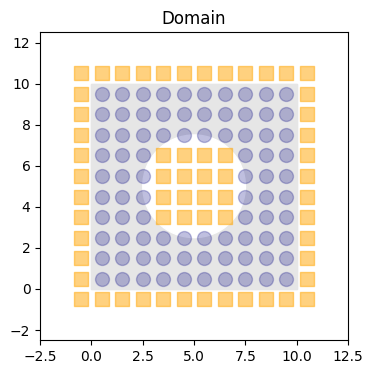

In [3]:
#first we plot the domain, a plate with hole geometry
sim.domain.visualize()

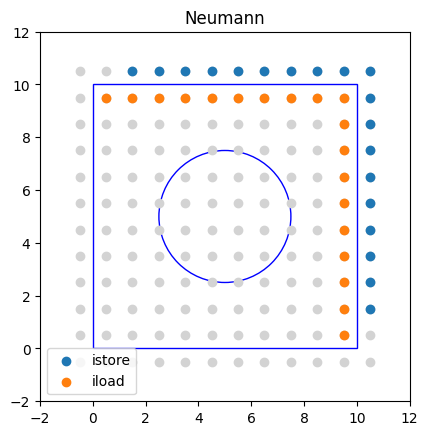

In [4]:
#now let's plot istore and iload for the Neumann bounds
#we choose a direction iv, and plot all nodes for which iv leaves the domain (iload)
#and all nodes for which sym(iv) enters the domain (istore) e.g. iv = 0 corresponds to v = (1,0) and sym(v) = (-1,0).
#hence, iv = 0 will give us all nodes on the right side of the square domain

#choose a direction iv = 0,1,2,...,7 
iv = 4
iv_sym = sim.scheme.stencil.get_symmetric()[iv]

#to plot we take the x and y indices of istore and iload for a given iv and obtain the
#domain coordinates with sim.domain.x_halo and sim.domain.y_halo for these indices
import matplotlib.pyplot as plt
circle = plt.Circle((0.5/L, 0.5/L), 0.25/L, color='blue',fill=False)
square = plt.Rectangle((0,0), 1/L, 1/L, color='blue',fill=False)
xmesh,ymesh = xv,yv = np.meshgrid(sim.domain.x_halo,sim.domain.y_halo,indexing='ij')
istore = sim.bc.methods[0].istore
iload = sim.bc.methods[0].iload[0]
idx_store = np.nonzero(istore[:,0] == iv_sym*np.ones(np.shape(istore[:,0])))
idx_load = np.nonzero(iload[:,0] == iv*np.ones(np.shape(iload[:,0])))
x_store = sim.domain.x_halo[istore[idx_store,1]]
x_load = sim.domain.x_halo[iload[idx_load,1]]
y_store = sim.domain.y_halo[istore[idx_store,2]]
y_load = sim.domain.y_halo[iload[idx_load,2]]
fig,ax=plt.subplots()
xv,yv = np.meshgrid(sim.domain.x_halo,sim.domain.y_halo)
ax.set_aspect('equal')
ax.add_patch(circle)
ax.add_patch(square)
ax.scatter(xv,yv,color='lightgrey')
ax.scatter(x_store,y_store,label='istore')
ax.scatter(x_load,y_load,label='iload')
ax.set_xlim(xmin=-0.2/L,xmax=1.2/L)
ax.set_ylim(ymin=-0.2/L,ymax=1.2/L)
ax.legend()
ax.set_title('Neumann')
plt.show()


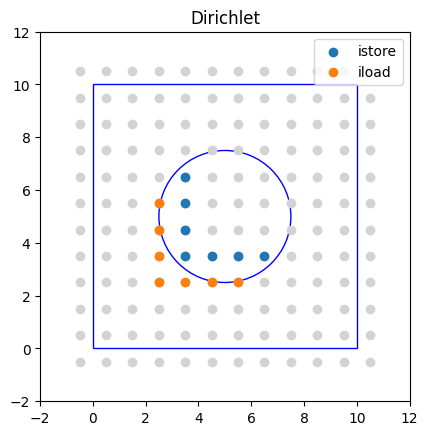

In [5]:
#now let's plot istore and iload for the Dirichlet bounds 

#choose a direction iv = 0,1,2,...,7 
iv = 4
iv_sym = sim.scheme.stencil.get_symmetric()[iv]

import matplotlib.pyplot as plt
circle = plt.Circle((0.5/L, 0.5/L), 0.25/L, color='blue',fill=False)
square = plt.Rectangle((0,0), 1/L, 1/L, color='blue',fill=False)
xmesh,ymesh = xv,yv = np.meshgrid(sim.domain.x_halo,sim.domain.y_halo,indexing='ij')
istore = sim.bc.methods[1].istore
iload = sim.bc.methods[1].iload[0]
idx_store = np.nonzero(istore[:,0] == iv_sym*np.ones(np.shape(istore[:,0])))
idx_load = np.nonzero(iload[:,0] == iv*np.ones(np.shape(iload[:,0])))
x_store = sim.domain.x_halo[istore[idx_store,1]]
x_load = sim.domain.x_halo[iload[idx_load,1]]
y_store = sim.domain.y_halo[istore[idx_store,2]]
y_load = sim.domain.y_halo[iload[idx_load,2]]
fig,ax=plt.subplots()
xv,yv = np.meshgrid(sim.domain.x_halo,sim.domain.y_halo)
ax.set_aspect('equal')
ax.add_patch(circle)
ax.add_patch(square)
ax.scatter(xv,yv,color='lightgrey')
ax.scatter(x_store,y_store,label='istore')
ax.scatter(x_load,y_load,label='iload')
ax.set_xlim(xmin=-0.2/L,xmax=1.2/L)
ax.set_ylim(ymin=-0.2/L,ymax=1.2/L)
ax.legend()
ax.set_title('Dirichlet')
plt.show()


Two other attributes that are important for the boundary conditions are `method.distance` which stores the distance to the border, normalized with the length of the lattice spacing (such that borders halfway between nodes have distance $0.5$ irrespective of whether the direction is axis aligned or diagonal), and `method.normal` which stores the outward facing normalized normal vector at the intersection of link and border. Let's plot these quantities for the Dirichlet bound:

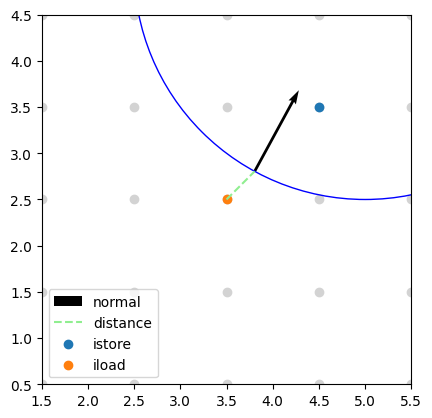

In [6]:
#we have 7 conditions for iv = 4, let's choose on of them to plot
icond = 4

x_store0 = x_store[0][icond]
y_store0 = y_store[0][icond]
x_load0 = x_load[0][icond]
y_load0 = y_load[0][icond]
normal = sim.bc.methods[1].normal[idx_load][icond]
distance = sim.bc.methods[1].distance[idx_load][icond]

fig, ax = plt.subplots()
circle = plt.Circle((0.5/L, 0.5/L), 0.25/L, color='blue',fill=False)
square = plt.Rectangle((0,0), 1/L, 1/L, color='blue',fill=False)
plt.quiver(x_load0+distance,y_load0+distance, normal[0], normal[1],scale=4,label='normal')
ax.plot([x_load0,x_load0+distance],[y_load0,y_load0+distance],color='lightgreen',label='distance',linestyle='--')
ax.scatter(xv,yv,color='lightgrey')
ax.scatter(x_store0,y_store0,label='istore')
ax.scatter(x_load0,y_load0,label='iload')
ax.set_aspect('equal')
ax.set_xlim(xmin=x_load0-2,xmax=x_load0+2)
ax.set_ylim(ymin=y_load0-2,ymax=y_load0+2)
ax.add_patch(circle)
ax.add_patch(square)
ax.legend(loc='lower left')
plt.show()

### 4. methods of the boundary classes
Now we will look closer at the methods our boundary classes use. Let's go backwards through the steps starting at the final generated code and track how we arrive there. Unless specified all listed source code is from `pylbm/boundary.py`. I will use the `LEDirichlet2D` class for examples.
To execute the generated code for the boundary conditions, the function `method.update` is called which is defined in the parent class (l.300)
```python
 def update(self, ff, **kwargs):
        """
        Update distribution functions with this boundary condition.

        Parameters
        ----------

        ff : array
            The distribution functions
        """
        from .symbolic import call_genfunction

        args = self._get_args(ff)
        args.update(kwargs)
        call_genfunction(self.function, args) #pylint: disable=no-member

```
`self.function` is the function handle for the generated code. Since this code is generated with symbolic expressions, we need a method to get all arguments with which the generated code is executed. Below we can see how the generated cython code looks like.  
```cython
def dirichlet_le(double[:, :, ::1] f, double[:, :, ::1] fcopy, int[:, ::1] iload0, int[:, ::1] istore, int ncond, int nx, int ny, double[::1] rhs):
    cdef int ix
    for ix in range(0, ncond):
        f[istore[ix, 1], istore[ix, 2], istore[ix, 0]] = fcopy[iload0[ix, 1], iload0[ix, 2], iload0[ix, 0]] + rhs[ix]
    #end
#end
```
The function `method._get_args(ff)` will provide all arguments needed to call this function, e.g. by relating `f = ff` where `f` is the argument of the cython function and `ff` is the actual container which stores all populations at every node (from the last time step). Also very clear in the cython code example is how we store the missing populations outside the domain (`istore` used for indexing on the LHS) using information from inside the domain (`iload` used for indexing on the RHS). Additionally the term `rhs` appears on the RHS, which acts as a source term that we can control.
The code is generated in the function `method.generate` which is specifically implemented for every boundary method class. Below is the function which generated the above cython code (l.635):
```python
def generate(self, sorder):
        """
        Generate the numerical code.

        Parameters
        ----------
        sorder : list
            the order of nv, nx, ny and nz
        """
        from .generator import For
        from .symbolic import nx, ny, nz, indexed, ix

        ns = int(self.stencil.nv_ptr[-1])
        dim = self.stencil.dim

        istore, iload, ncond = self._get_istore_iload_symb(dim)
        rhs, _ = self._get_rhs_dist_symb(ncond)

        idx = Idx(ix, (0, ncond))
        fstore = indexed('f', [ns, nx, ny, nz], index=[istore[idx, k] for k in range(dim+1)], priority=sorder)
        fload = indexed('fcopy', [ns, nx, ny, nz], index=[iload[0][idx, k] for k in range(dim+1)], priority=sorder)

        self.generator.add_routine(('dirichlet_le', For(idx, Eq(fstore, fload + rhs[idx]))))

```
The important part is the last line. There we specify exactly what code we want to generate: `For` is a class describing a for-loop, `idx` is the loop counter. Next we have the expression which is looped, `Eq(fstore, fload + rhs[idx])`, which translates to `fstore[appropriate index] = fload[appropriate index] + rhs[idx]`. I have written 'appropriate index' as `fstore` and `fload` are not directly indexed with `idx` but in the way that is defined in the two lines above the last line. But as we can see, this expression defines exactly what is generated in the cython code. A very important point is that all variables at this point are not the actual arrays and variables carrying the numerical values but merely __symbols__ with the same name as the corresponding variables. As we saw before, the function `method._get_args` is responsible for relating these symbols to actual variables with numerical values. This is done by collecting all variables and their names in a dictionary with `locals()` (which is why the symbols and actual variables need to have the same name). If we wanted to introduce general changes about how missing populations are reconstructed, this is the point where it would be done. 
Continuing on, let's see how `rhs` is constructed (the actual variable):  
```python
def set_rhs(self):
        """
        Compute and set the additional terms to fix the boundary values.
        """
        self.rhs[:] = self.s_0 + self.s_1

```
The above code is for the Dirichlet boundary conditions where the source term is comprised of two terms $s_0$ and $s_1$. As we can see, these two terms are not actually computed in `method.set_rhs` but simply added to get the final rhs-term. As we saw in section 2, this function is called both in the initalization of the boundary class and in every time step of the simulation.

The terms `s_0` and `s_1` are built in different methods. To compute these, we repurpose some existing methods in such a way that we don't have to change the higher level structures in `pylbm/simulation.py` which would render all already existing boundary methods unusable just for the sake of making our implementations work. `s_0` only has to computed once and will not change during simulation. Therefore we can use the function `method.prepare_rhs` which is only called during initialization. I won't copy the entire function here, to summarize, this function adopts the functions which contain the expressions for the value at the boundary, given at `'value'` in the dictionary and computes this expression at all boundary points (meaning at the actual intersection between outgoing links of boundary nodes and the border). The order of the resulting array will be the same as `istore` and of shape $(N_{cond},2)$ (meaning $N_{cond}$ boundary conditions for both x and y directions). We can then use this array to compute `s_0`.

`s_1` on the other hand has to be recalculated at every timestep. For this purpose we can use the function `method.update_feq` which is called in every time step as is shown in section 2 (sidenote: the names of the methods may not really be descriptive of what is happening inside them but have to be consistent with all other boundary method classes). Again, I won't replicate the entire contents of the function here, the important points are that this function is called every time step and that the function is called with `simulation` as argument which lets us access simulation parameters like time, moments and populations which are needed to compute `s_1`. 

The implementation for `LENeumann2D` follows a very similar approach. The major additions with this method are a neighbor search and and a generalized bounce-back for boundary nodes, but more on that in the following section.   

A note of caution: `method.fix_iload` transposes `iload` and `istore`. As we see in section 2, this function is called __after__ `method.prepare_rhs`, meaning that both arrays have shape $(3,N_{cond})$ inside `method.prepare_rhs` and before, and shape $(N_{cond},3)$ after `method.fix_iload` has been called (hence for the rest of the simulation).

### 5. Neumann
The last section gave a more detailed explanation about the inner workings of the boundary method classes with examples from the Dirichlet class in particular. The Neumann boundary conditions are overall computed similarly, with some added complexity as we will see below.

For starters, the Neumann boundary conditions are computed as some generalized bounce-back in the sense that we use all available populations at a boundary node to reconstruct missing incoming populations instead of just the outgoing one as before. At every boundary node, the missing population is reconstructed as `fstore=a_ijkl*fload+rhs`. Importantly, `fload` here denotes a 1D-array of all 8 populations at the boundary node. Similarly, `a_ijkl` is a 1D-array of 8 coefficients for the linear combination of populations through the scalar product `*`. That equation is of course used for every boundary conditions, with `a_ijkl` depending on the direction of the missing population, meaning `a_ijkl` will be of shape $(N_{cond},8)$. `a_ijkl` can be precomputed in the initialization, i.e. in `method.prepare_rhs` and won't change during the simulation. All this is reflected in a change to `method.generate`:
```python
 def generate(self, sorder):
        """
        Generate the numerical code.

        Parameters
        ----------
        sorder : list
            the order of nv, nx, ny and nz
        """
        from .generator import For
        from .symbolic import nx, ny, nz, indexed, ix
        from sympy import Add

        ns = int(self.stencil.nv_ptr[-1])
        dim = self.stencil.dim

        istore, iload, ncond = self._get_istore_iload_symb(dim)
        rhs, _ = self._get_rhs_dist_symb(ncond)
        a_ijkl = IndexedBase('a_ijkl', [ncond,self.stencil.unvtot])

        idx = Idx(ix, (0, ncond))
        fstore = indexed('f', [ns, nx, ny, nz], index=[istore[idx, k] for k in range(dim+1)], priority=sorder)

        fload = []
        for ij in range(ns):
            fload.append(indexed('f', [ns, nx, ny, nz], index=[ij,iload[0][idx, 1], iload[0][idx, 2]],priority=sorder))

        self.generator.add_routine(('neumann_le', For(idx, Eq(fstore, Add(*[a_ijkl[idx,ij]*fload[ij] for ij in range(ns)]) + rhs[idx]))))
```
Note the last line, where this generalized bounce-back is formulated (also note the sympy import to get `sympy.Add` which lets us express the scalar product in terms of symbols). Again, in this function only symbols are used and not variables which point to actual values, which is why `a_ijkl` in this function is declared as a `sympy.IndexedBase` object. Like the Dirichlet method, we additionally have a source term `rhs`. The way this is constructed is similar to before, except that the individual terms which make up `rhs` are now called `s_1` and `s_2`, where the former can be pre-calculated during the initialization and the latter has to be computed anew in every timestep:
```python
def set_rhs(self):
        """
        Compute and set the additional terms to fix the boundary values.
        """
        self.rhs[:] = self.s_1 + self.s_2

```
Again, `method.set_rhs` doesn't actually calculate the individual terms but simply adds them together. The term `s_1` is calculated very similarly to `s_0` in the Dirichlet class, so will not be further explained here. `s_2` however is more involved; leaving aside here explanations of why this is the case, let's focus on what we have to do concretly to get `s_2`, which basically boils down to a large case distinction for every boundary node. This might also be a good moment to mention that for the computation of `s_2`, information from nodes neighboring the boundary nodes is needed.

        incoming population has axis aligned travel direction:
        
            s_2 = ...
        
        incoming population has diagonal travel direction:
        
            boundary is closer to being horizontal than vertical:
            
                boundary node has a neighbor node in vertical direction:
                
                    s_2 = ...
                    
                boundary node has a neighbor node in diagonal direction:
                
                    s_2 = ...
                    
                boundary node has no neighbor in vertical or diagonal direction:
                
                    s_2 = 0
                    
            boundary is closer to being vertical than horizontal:
            
                boundary node has a neighbor node in horizontal direction:
                
                    s_2 = ...
                    
                boundary node has a neighbor node in diagonal direction:
                
                    s_2 = ...
                    
                boundary node has no neighbor in horizontal or diagonal direction:
                
                    s_2 = 0
Actually looping over boundary nodes and distinguishing these cases verbosely with nested `if` statements would be very undesirable performance-wise. Instead, since we are manipulating numpy arrays to calculate `s_2`, we can create masks for indexing. For example, a mask can be created to only select boundary conditions with diagonal direction of the missing population like:
```python
mask_diag = istore[:,0] > 3
```
As `istore` stores the travel directions of missing incoming populations in the first column, the above statement will create a boolean array which tells if this direction is diagonal or not. We could then, for example get all x indices of boundary nodes for all boundary conditions with diagonal directions with
```python
x_ind_diag = iload[0][mask_diag,1]
```
A very conveniant feature of these masks is that they can be chained together with logical operations. If we have, for example, another mask `mask_vert`, which tells us for every boundary condition whether the border is aligned more vertically than horizontally or not, we could select all x indices of boundary nodes for all boundary conditions for which: _the direction of the missing incoming population is diagonal __and__  the orientation of the boundary is more vertical than horizontal_: 
```python
x_ind_diag_vert = iload[0][mask_diag&mask_vert,1]
```
We can see that this transforms the large case distinction above in to a problem of creating appropriate masks. I won't replicate all code used in creating all necessary masks here, but simply list them with a description:

        mask_diag         : all BCs with diagonal travel direction
        mask_hori         : all BCs where boundary orientation is closer to horizontal than vertical
        mask_vert         : all BCs where boundary orientation is closer to vertical than horizontal (==not(mask_hori))
        has_ax_neighbor   : all BCs with diagonal travel direction and axis aligned neighbor (only counting those in the
                            correct direction, consistent with mask_hori and mask_vert)
        has_diag_neighbor : all BCs with diagonal travel direction and only diagonal neighbor (no axis neighbor available)
        
Note 1: we preferably use axis aligned neighbors if they are available.
Note 2: in some places in the code, not masks but index arrays are used, like `ind_diag`. These are mostly equivalent to the masks, apart from actually storing indices. They are related to the mask like `ind_diag=np.where[mask_diag][0]` and can be used for indexing the same way. In hindsight, using masks consistently throughout the code would have been cleaner but it is what it is.   

Another important object that should be briefly described is called `iload_neighbor`. This is a shape $(N_{cond},3)$ array, similar to `iload`, which stores in the second and third column the x and y indices of the neighbor nodes for all boundary conditions where this information is needed (otherwise having zeros). The first column stores the direction which points from the neighbor node to the corresponding boundary node. Additionally, a flag `-1` is set in the first column if for that boundary condition no neighbor node is available.

The neighbor search itself can be sketched out as follows (in some pylbm-python pseudo-code, not writing out the actual syntax):
```python        
#initialize arrays
has_ax_neighbor = zeros(shape(mask_diag),type=bool)
has_diag_neighbor = zeros(shape(mask_diag),type=bool)

#get x and y indices of boundary nodes (remember we only need neighbors for diagonal BC directions)
[x,y]= iload[mask_diag,1:]

#since x and y are already masked, we mask the masks to get the right shapes, mask_hori and mask_vert are now equivalent
#to mask_hori&mask_diag and mask_vert&mask_diag
mask_hori = mask_hori[mask_diag]
mask_vert = mask_vert[mask_diag]

#find vertical neighbors for more close to horizontal boundaries
for iv in [1,3]:

    #test if we are in the domain after stepping in direction iv from the boundary node  
    search = is_inside_domain(x[mask_hori]+vx[iv],y[mask_hori]+vy[iv])

    #updating the array 
    has_ax_neighbor = has_ax_neighbor or search

#find diagonal neighbors for more close to horizontal boundaries
for iv in [4,5,6,7]:

    #test if we are in the domain after stepping in direction iv from the boundary node  
    search = is_inside_domain(x[mask_hori]+vx[iv],y[mask_hori]+vy[iv])

    #updating the array 
    has_diag_neighbor = has_diag_neighbor or search

#find horizontal neighbors for more close to vertical boundaries
for iv in [0,2]:

    #test if we are in the domain after stepping in direction iv from the boundary node  
    search = is_inside_domain(x[mask_vert]+vx[iv],y[mask_vert]+vy[iv])

    #updating the array 
    has_ax_neighbor = has_ax_neighbor or search

#find diagonal neighbors for more close to vertical boundaries
for iv in [4,5,6,7]:

    #test if we are in the domain after stepping in direction iv from the boundary node  
    search = is_inside_domain(x[mask_vert]+vx[iv],y[mask_vert]+vy[iv])

    #updating the array 
    has_diag_neighbor = has_diag_neighbor or search

#discard search hits for diagonal neighbors if an axis aligned neighbor is available
has_diag_neighbor = has_diag_neighbor and not has_ax_neighbor
```        
Not included in this pseudo-code is that in all these for-loops, the directions pointing from the neighbor that will be used in the end to the corresponding boundary node are collected and stored in `iload_neighbor`, as well as the neighbor node indices. (While writing this it occurs to me that the search for diagonal neighbors could be summarized in a single for-loop). 

With all these masks and neighbors we can finally calculate the appropriate source terms `s_2` for all boundary nodes and for all distinct cases listed above. This largely involves computing stress derivatives from the moments (which also have to transformed from post collision moments to bared moments) at the boundary nodes (and if needed, their neighbor). 

A final note: Both Neumann and Dirichlet boundary methods need material parameters for their computations. For lack of a better way of communicating these parameters to the boundary classes, they are hardcoded to be taken from the `'parameter'` dictionary inside the main simulation-defining dictionary, with keys `'K_ND'`, `'MU_ND'`, `'THETA'` (example below). Furthermore these boundary classes expect the simulation to be nondimensionalized and scaled to lattice units. Since pylbm doesn't have any kind of unit handling system, this nondimensialization is up to the user to perform before defining a dictionary.
```python
#how the material parameters should be defined:
import sympy as sp

#symbols for the nondimensional material parameters
#exactly these names have to be used
K_ND, MU_ND, THETA = sp.symbols('K_ND, MU_ND, THETA')

#numerical values of the nondimensional material parameters
k_nd = 1.
mu_nd = 1.
theta = 1/3

dico = {
    ...
    ...
    'parameters': {K_ND: k_nd,
                   MU_ND: mu_nd,
                   THETA: theta,
                   ...
                  }
    ...
    ...
}

```
